In [8]:
import kagglehub
import os
kaggle_dir="ikarus777/best-artworks-of-all-time"

data_dir=kagglehub.dataset_download(kaggle_dir)
data_dir=os.path.join(data_dir,'images','images')
print(data_dir)

/root/.cache/kagglehub/datasets/ikarus777/best-artworks-of-all-time/versions/1/images/images


In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

# ===================================================================
# 1. 특정 화가만 선택하는 커스텀 데이터셋 클래스 정의
# ===================================================================
class ArtistSubsetDataset(Dataset):
    def __init__(self, data_dir, artists_to_include, transform=None):
        """
        Args:
            data_dir (string): 'images/images' 와 같이 화가 폴더들이 있는 경로.
            artists_to_include (list): 포함할 화가 이름의 리스트.
            transform (callable, optional): 샘플에 적용될 transform.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.artists_to_include = artists_to_include
        
        self.image_paths = []
        self.labels = []
        
        # 선택된 화가들을 기준으로 클래스와 인덱스를 매핑
        self.class_names = sorted(self.artists_to_include)
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        self.classes=self.class_names
        
        print(f"선택된 화가들로 데이터셋을 구성합니다: {self.class_names}")

        # 선택된 화가 폴더만 순회
        for artist_name in self.class_names:
            artist_path = os.path.join(data_dir, artist_name)
            
            if not os.path.isdir(artist_path):
                print(f"경고: '{artist_name}' 폴더를 찾을 수 없습니다. 건너뜁니다.")
                continue
            
            # 해당 화가의 모든 이미지 파일 경로와 레이블을 리스트에 추가
            for file_name in os.listdir(artist_path):
                # .jpg, .png 등 이미지 파일만 추가
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(artist_path, file_name))
                    self.labels.append(self.class_to_idx[artist_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx:int)->tuple[torch.Tensor,torch.Tensor]:
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # 이미지를 3채널(RGB)로 불러오기 (전이 학습 모델 호환)
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"이미지 로드 에러: {image_path}, 에러: {e}")
            # 에러 발생 시, 임의의 검은 이미지와 레이블 반환 또는 다른 이미지로 대체
            return torch.randn(3, 224, 224), torch.tensor(label)


        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

In [10]:
import torch



# 1. 기본 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 디바이스: {device}")


현재 사용 중인 디바이스: cuda


In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]


IMG_SIZE = 224
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

ARTISTS_TO_INCLUDE = [
    "Vincent_van_Gogh",
    "Claude_Monet",
    "Leonardo_da_Vinci",
    "Rembrandt",
    "Pablo_Picasso"
    # "Edgar Degas",
    # "Salvador Dali",
    # "Paul Cezanne"
]

test_dataset = ArtistSubsetDataset(
    data_dir=data_dir, 
    artists_to_include=ARTISTS_TO_INCLUDE, 
    transform=test_transforms
)
class_names=test_dataset.classes
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=14,pin_memory=True)


선택된 화가들로 데이터셋을 구성합니다: ['Claude_Monet', 'Leonardo_da_Vinci', 'Pablo_Picasso', 'Rembrandt', 'Vincent_van_Gogh']


In [26]:
import torch
from dir_util import WORKSPACE_DIR
from attention_model import AttentionCNN

best_model_dir=os.path.join(WORKSPACE_DIR,'250621_1017_AttentionCNN_Grayscale_lr0.001best_model.pt')
model = AttentionCNN(num_classes=len(test_dataset.classes))

model.load_state_dict(torch.load(best_model_dir))
model=model.to(device=device)

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def display_images_from_dict(img_dict, num_cols=3, main_title=None, bottom_text=None):
    """
    딕셔너리에 있는 NumPy 배열 이미지들을 격자 형태로 표시합니다.
    전체 제목과 하단 텍스트를 추가하는 기능이 포함되어 있습니다.

    Args:
        img_dict (dict): 키는 이미지 제목(str), 값은 이미지(np.ndarray)인 딕셔너리.
        num_cols (int): 한 줄에 표시할 이미지의 개수.
        main_title (str, optional): 그림 상단에 표시될 전체 제목.
        bottom_text (str, optional): 그림 하단 중앙에 표시될 텍스트.
    """
    num_images = len(img_dict)
    if num_images == 0:
        print("표시할 이미지가 없습니다.")
        return
        
    num_rows = (num_images + num_cols - 1) // num_cols
    
    # figsize을 조금 더 늘려서 제목과 텍스트 공간 확보
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 5.0))
    
    # axes가 1차원 배열이 되도록 변환
    axes = axes.flatten()
    
    # 각 서브플롯에 이미지와 제목 표시
    for i, (title, img_array) in enumerate(img_dict.items()):
        ax:plt.Axes = axes[i]
        
        if img_array.ndim == 2:
            ax.imshow(img_array, cmap='gray')
        else:
            ax.imshow(img_array)
        
        ax.set_title(title, fontsize=12)
        ax.axis('off')

    # 남는 빈 subplot들은 끄기
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    # --- ★★★ 핵심 추가 부분 ★★★ ---
    
    # 1. 전체 메인 제목 추가
    if main_title:
        fig.suptitle(main_title, fontsize=20, y=0.98) # y 값으로 제목의 높이 조절
        
    # 2. 전체 하단 텍스트 추가
    if bottom_text:
        # fig.text(x, y, text, ...): 그림 전체를 기준으로 텍스트 위치 지정
        # (0,0)은 왼쪽 아래, (1,1)은 오른쪽 위
        # x=0.5: 가로 중앙
        # y=0.05: 아래에서 5% 위치
        # ha='center': 텍스트를 가로 중앙 정렬
        fig.text(0.5, 0.05, bottom_text, ha='center', fontsize=14, style='italic', color='gray')
    
    # --------------------------------

    plt.tight_layout()
    # suptitle과 tight_layout이 겹칠 수 있으므로, rect로 조절
    if main_title:
        plt.subplots_adjust(top=0.92) # 메인 제목과 서브플롯 간의 간격 조절

    plt.show()

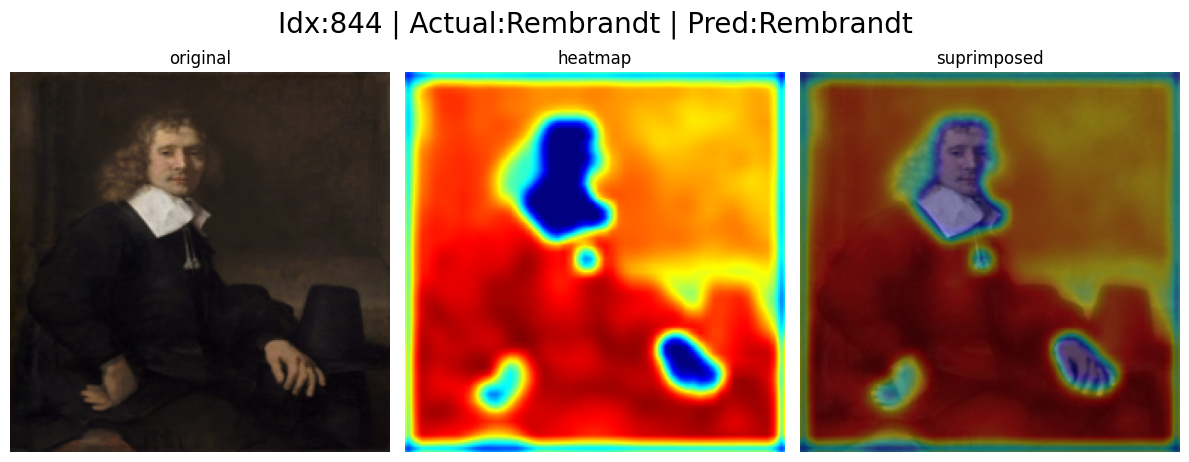

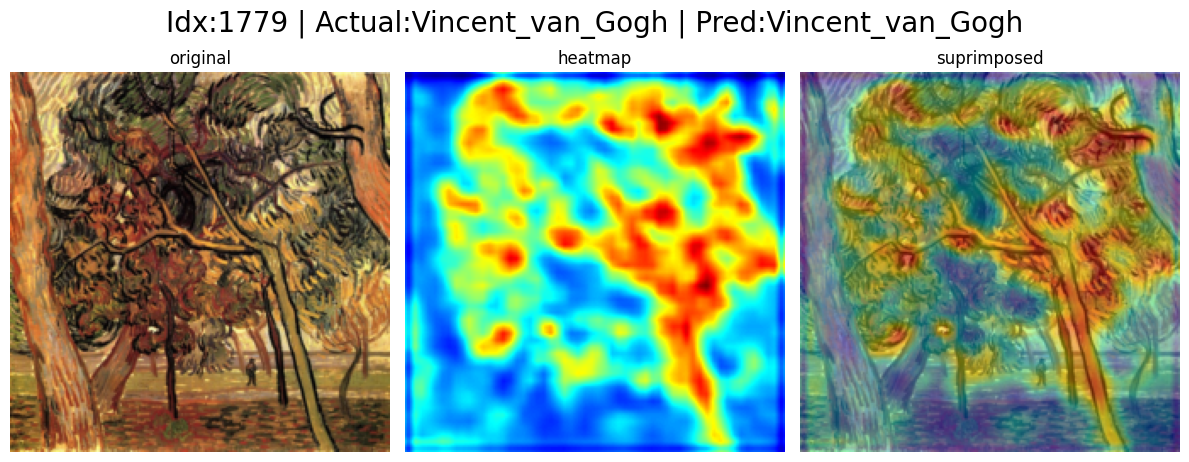

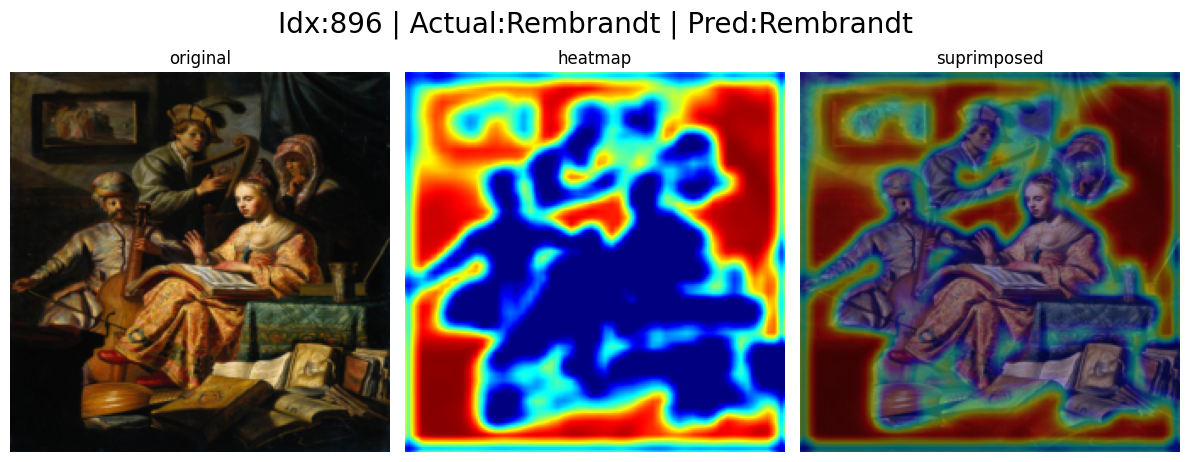

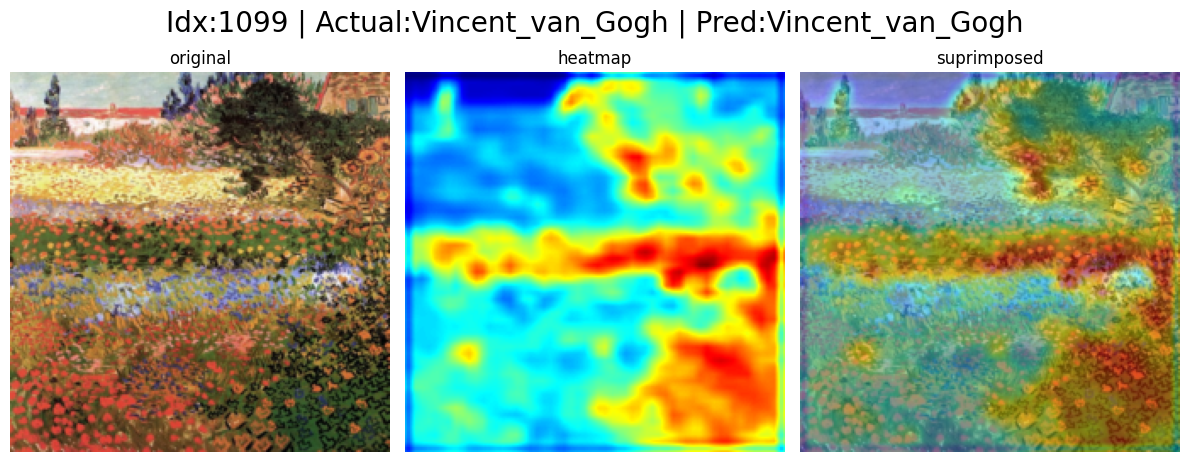

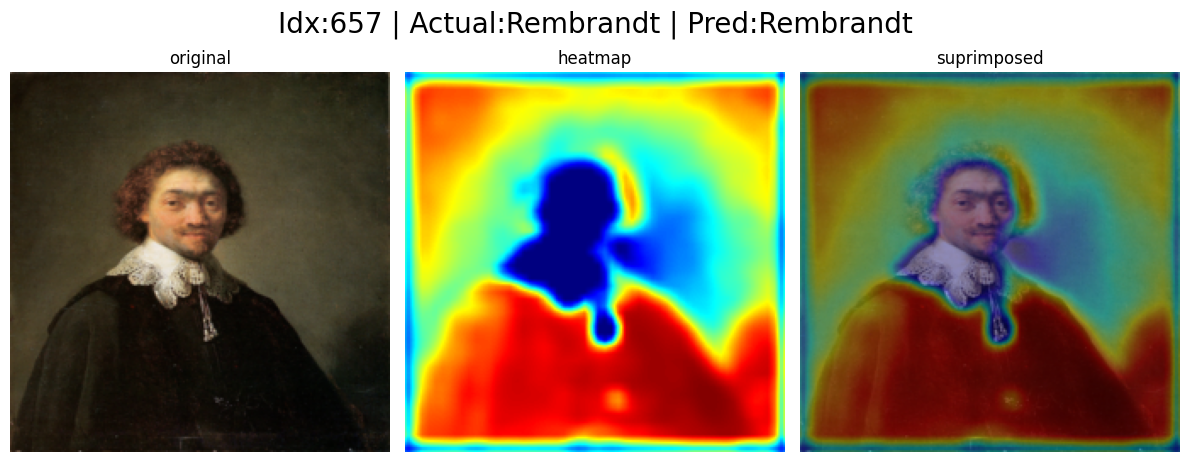

In [28]:

from visualize import image_to_res
import random

# 시각화할 이미지 인덱스 선택
indices_to_visualize = random.sample(range(len(test_dataset)), 5) # 5개 랜덤 샘플
for idx in indices_to_visualize:
    image,label=test_dataset[idx]
    image=image.unsqueeze(0)
    predict_label,img_dict=image_to_res(model=model,image=image,img_mean=IMG_MEAN,img_std=IMG_STD,device=device)
    
    title = f"Idx:{idx} | Actual:{class_names[label]} | Pred:{class_names[predict_label]}"
        
    display_images_from_dict(img_dict, num_cols=3,main_title=title)